In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import psycopg2
from dotenv import load_dotenv

PROJECT_ROOT = Path.cwd().parent

load_dotenv()

conn = psycopg2.connect(
    host=os.getenv("DB_HOST", "127.0.0.1"),
    port=os.getenv("DB_PORT", "5432"),
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
)

query = """
SELECT image_id, filepath, label, split, width, height, channels
FROM images
ORDER BY image_id;
"""

df = pd.read_sql_query(query, conn)
conn.close()

df.head()


C:\Users\simon\AppData\Local\Temp\ipykernel_16792\3708573412.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,image_id,filepath,label,split,width,height,channels
0,1,data/raw_flat/plastic/plastic92.jpg,plastic,train,512,384,3
1,2,data/raw_flat/cardboard/cardboard305.jpg,cardboard,train,512,384,3
2,3,data/raw_flat/cardboard/cardboard53.jpg,cardboard,train,512,384,3
3,4,data/raw_flat/cardboard/cardboard42.jpg,cardboard,train,512,384,3
4,5,data/raw_flat/metal/metal141.jpg,metal,train,512,384,3


### SANITY CHECK

In [2]:
print("Totale immagini:", len(df))
print("\nSplit distribution:")
print(df["split"].value_counts())

print("\nClass distribution:")
print(df["label"].value_counts())


Totale immagini: 2527

Split distribution:
split
train    1768
test      380
val       379
Name: count, dtype: int64

Class distribution:
label
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64


Abbiamo tutte le immagini, split coerente 70/15/15 e per ogni immahine ho un valore di classe (la meno rappresentata è trash)

### VERIFICA DIMENSIONI E CANALI

In [3]:
df.groupby(["width", "height", "channels"]).size()


width  height  channels
512    384     3           2527
dtype: int64

Tutte con dimensioni e canali uguali.

### Distribuzione classi per split

In [4]:
pd.crosstab(df["split"], df["label"], normalize="index")


label,cardboard,glass,metal,paper,plastic,trash
split,,,,,,
test,0.157895,0.200000,0.163158,0.234211,0.192105,0.052632
train,0.159502,0.197964,0.162330,0.235294,0.190611,0.054299
val,0.160950,0.197889,0.160950,0.234828,0.189974,0.055409


Lo split stratificato mantiene le proporzioni tra classi tra train validation e test set

### EDA VISIVA - CAMPIONI PER CLASSE

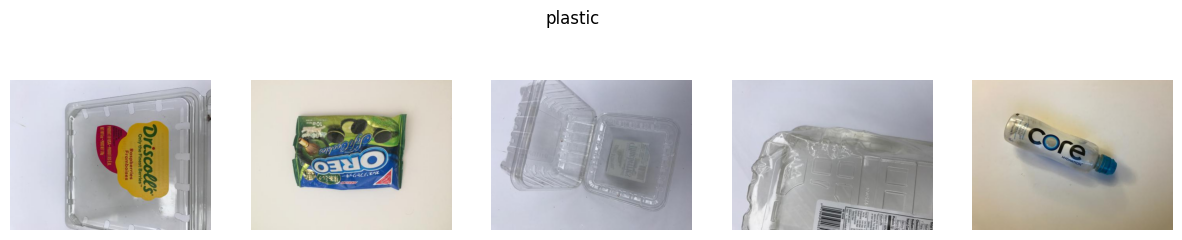

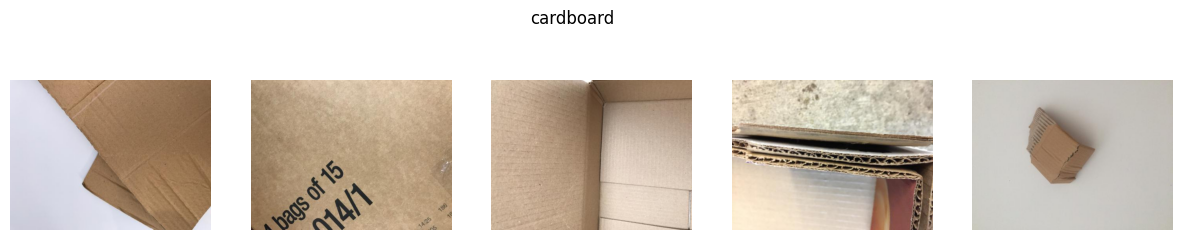

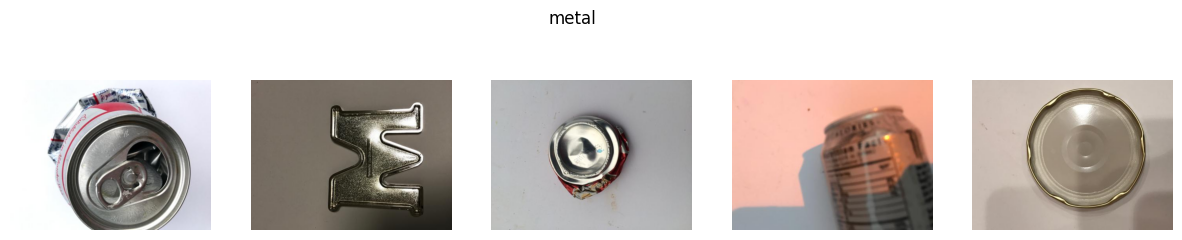

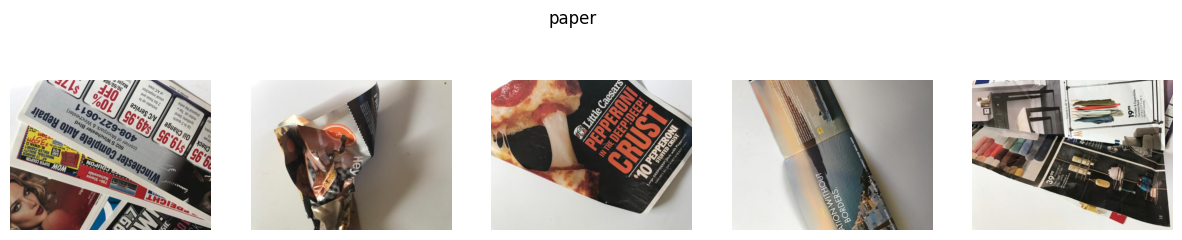

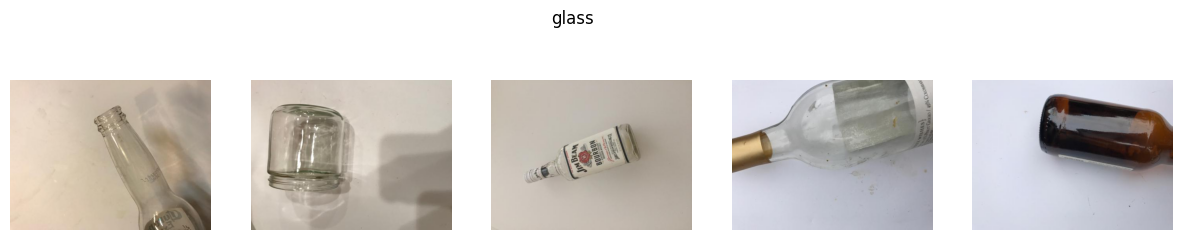

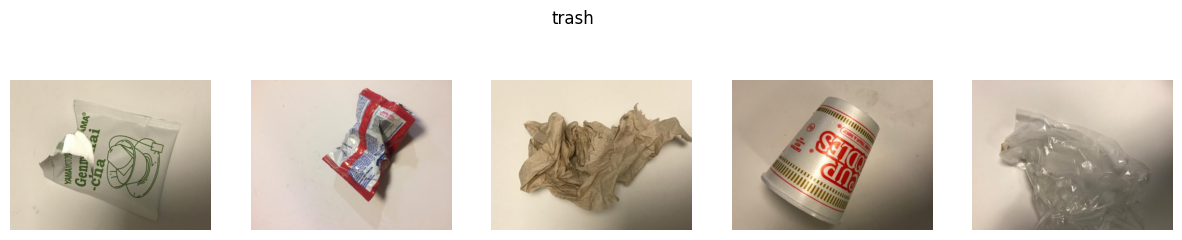

In [7]:
def abs_path(rel_posix: str) -> Path:
    return PROJECT_ROOT / Path(rel_posix)

def show_samples(df, label, n=6):
    samples = df[df["label"] == label].sample(n, random_state=42)
    fig, axes = plt.subplots(1, n, figsize=(15,3))
    for ax, (_, r) in zip(axes, samples.iterrows()):
        img = Image.open(abs_path(r["filepath"]))
        ax.imshow(img)
        ax.axis("off")
    plt.suptitle(label)
    plt.show()

for lbl in df["label"].unique():
    show_samples(df[df["split"] == "train"], lbl, n=5)


Visualizza qualche esempio di immagine presa per ogni classe.

### Analisi pixel-level

In [8]:
img = np.array(Image.open(abs_path(df.iloc[0]["filepath"])))

print("Min:", img.min())
print("Max:", img.max())
print("Mean:", img.mean())


Min: 0
Max: 255
Mean: 155.02240329318576


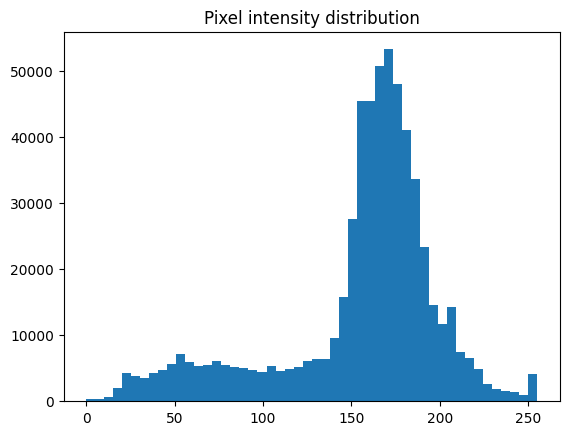

In [9]:
plt.hist(img.flatten(), bins=50)
plt.title("Pixel intensity distribution")
plt.show()
